# Fixed-point Search

The *Grover's quantum search* (GQS) has been proved to be optimal, but it requires priori knowledge of the number of solutions, otherwise excessive iterations will *overcook* the state.
An awesome improvement is the fixed-point search, which only requires a lower bound of iterations and the state will stay tight around the solution without worrying about overcooking.
This makes fixed-point search based algorithms completely coherent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_chebyt
from scipy.optimize import brentq

## Modified Grover's Operator

In general, the GQS aims to approximate a target state $\ket{t}$ (the uniform superposition of all solution states) from an easy-to-construct initial state $\ket{s}$ (the uniform superposition state).
Let the uniform superposition of non-solution states be $\ket{\bar{t}}$, and let $\ket{s} = \sin(\phi/2) \ket{t} + \cos(\phi/2) \ket{\bar{t}} = \sqrt{\lambda} \ket{t} + \sqrt{1-\lambda} \ket{\bar{t}}$.

The modified Grover's operator is defined as,

$$
\begin{align}
G(\alpha, \beta) &= S_s(\alpha) S_t(\beta), \\
S_s(\alpha) &= I - (1 - e^{i\alpha}) \ket{s}\bra{s},\\
S_t(\beta)  &= I - (1 - e^{i\beta})  \ket{t}\bra{t},
\end{align}
$$

which is exactly the Grover's operator when $\alpha=\beta=\pi$.
The global phase doesn't matter here.

In the 2-dim subspace spanned by $\ket{1}:=\ket{t}$ and $\ket{0}:=\ket{\bar{t}}$, define

$$
\begin{align}
    R_\varphi(\theta) &= \exp\left[-\frac{i\theta}{2}(Z\cos\varphi + X\sin\varphi )\right], \\
    A_\zeta           &= \exp[-\frac{i\phi}{2}(Y\cos\zeta + X\sin\zeta )],
\end{align}
$$

then,

$$
\begin{align}
    S_s(\alpha) &= e^{i\alpha/2} R_\phi(-\alpha), \\
    S_t(\beta)  &= e^{i\beta/2}  R_\phi(\beta).
\end{align}
$$

```{note}
The notation is slightly different from the original paper.
```

Note that,

$$
\begin{align}
    R_\phi(\alpha)   &= A_0 R_0(\alpha) A_{\pi}, \\
    A_{\alpha+\beta} &= R_0(-\beta)A_{\alpha}R_0(\beta).
\end{align}
$$

Using a seuqential of $\{G(\alpha_k, \beta_k)\}_{k=1}^l$, the final state is

$$
\begin{align}
    &
    G(\alpha_l, \beta_l) \cdots G(\alpha_1, \beta_1) \ket{s}
    \\ = &
    R_\phi(-\alpha_l) R_0(\beta_l) \cdots R_\phi(-\alpha_1) R_0(\beta_1) A_0 \ket{0}
    \\ = &
    A_0 R_0(-\alpha_l) A_{\pi} R_0(\beta_l) A_0 \cdots A_0 R_0(-\alpha_1) A_{\pi} R_0(\beta_1) A_0 \ket{0}
    \\ := &
    R_0\left(\sum\nolimits_j(-\alpha_j+\beta_j)\right) A_{\zeta_L} \cdots A_{\zeta_1} \ket{0},
\end{align}
$$

where $L=2l+1$, $\zeta_{2k+1} = -\alpha_k+\beta_k+\cdots-\alpha_1+\beta_1$ and $\zeta_{2k} = \pi+\beta_k+\cdots-\alpha_1+\beta_1$.

Let $(a_k, b_k)^T = A_{\zeta_k} \cdots A_{\zeta_1} \ket{0}$, using

$$
A_{\zeta_k} = 
\begin{pmatrix}
\cos\frac{\phi}{2}              & -e^{i\zeta_k}\sin\frac{\phi}{2} \\
e^{-i\zeta_k}\sin\frac{\phi}{2} & \cos\frac{\phi}{2}
\end{pmatrix},
$$

then,

$$
a_k = \cos\frac{\phi}{2} a_{k-1} - e^{i\zeta_k}\sin\frac{\phi}{2} b_{k-1}.
$$

Using $(a_{k-2}, b_{k-2})^T = A_{\zeta_{k-1}}^\dagger (a_{k-1}, b_{k-1})^T$, we have

$$
a_{k-2} = \cos\frac{\phi}{2} a_{k-1} + e^{i\zeta_{k-1}}\sin\frac{\phi}{2} b_{k-1}.
$$

Therefore,

$$
a_k = \cos\frac{\phi}{2} (1 + e^{i(\zeta_k-\zeta_{k-1})}) a_{k-1} - e^{i(\zeta_k-\zeta_{k-1})} a_{k-2},
$$

where

$$
\zeta_k - \zeta_{k-1} = 
\begin{cases}
    \pi + \beta_{k/2},     & k\text{ even},\\
    -\pi - \alpha_{(k-1)/2}, & k\text{ odd}.
\end{cases}
$$

The $R_0$ operator in the end doesn't change the amplitude of $\ket{0}$.
The final success probability (i.e. the measurement on computational basis returns one) is $P_L=1-|a_L|^2$, so we can use this recursion formula to calculate the error probability.

In [2]:
def success_probability(alpha_list, beta_list, sqrt_one_minus_lambda):
    if len(alpha_list) == 0:
        return 1 - sqrt_one_minus_lambda**2
    a_km2 = 1 # a_0
    a_km1 = sqrt_one_minus_lambda # a_1
    a_k = 0
    for alpha, beta in zip(alpha_list, beta_list):
        # Even k
        e_i_delta_zeta = -np.exp(1j * beta)
        a_k = sqrt_one_minus_lambda * (1 + e_i_delta_zeta) * a_km1 - e_i_delta_zeta * a_km2
        a_km2 = a_km1
        a_km1 = a_k
        # Odd k
        e_i_delta_zeta = -np.exp(1j * -alpha)
        a_k = sqrt_one_minus_lambda * (1 + e_i_delta_zeta) * a_km1 - e_i_delta_zeta * a_km2
        a_km2 = a_km1
        a_km1 = a_k
    return 1 - np.abs(a_k)**2

## Algorithms

In [3]:
# Simulation parameters
max_l = 150
lambda_list = [0.001, 0.01, 0.1, 0.5, 0.9]

### The original Grover's search

The results are well known: $P_L = \sin^2[(2l+1)\phi]$.

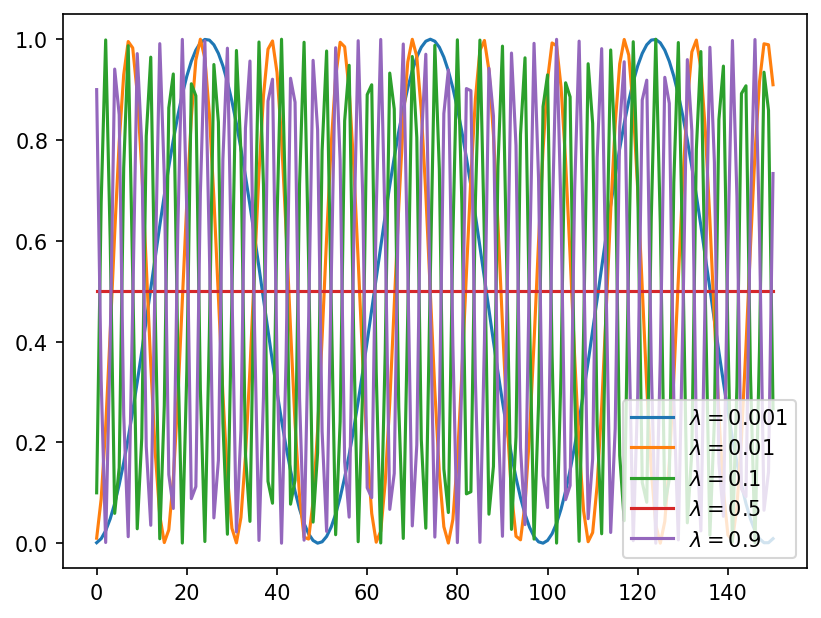

In [4]:
plt.figure(dpi=150)
for _lambda in lambda_list:
    plt.plot(range(max_l+1),
        [success_probability(np.ones(l)*np.pi, np.ones(l)*np.pi, np.sqrt(1-_lambda)) for l in range(max_l+1)], 
        label=f'$\\lambda={_lambda}$')
plt.legend()
plt.show()

```{admonition} Todo
Add the Grover's search without priori knowledge algorithm.
```

### The Grover's $\pi/3$-search

The original article gives a really nice deduction, so I only present the results:
if $l=\frac{3^m-1}{2}(m\in\mathbb{Z})$ Grover's operator is used, then

$$
P_L = 1-\left[\cos^2\frac{\phi}{2}\right]^{2l+1}.
$$

The $\alpha$ and $\beta$ list is defined by recursion, see the code below.

One can see the power of fixed-point search from the result.
But since the rotation angle is much less than $\pi$, the increasing is much slower than the original Grover's search for small $\lambda$.

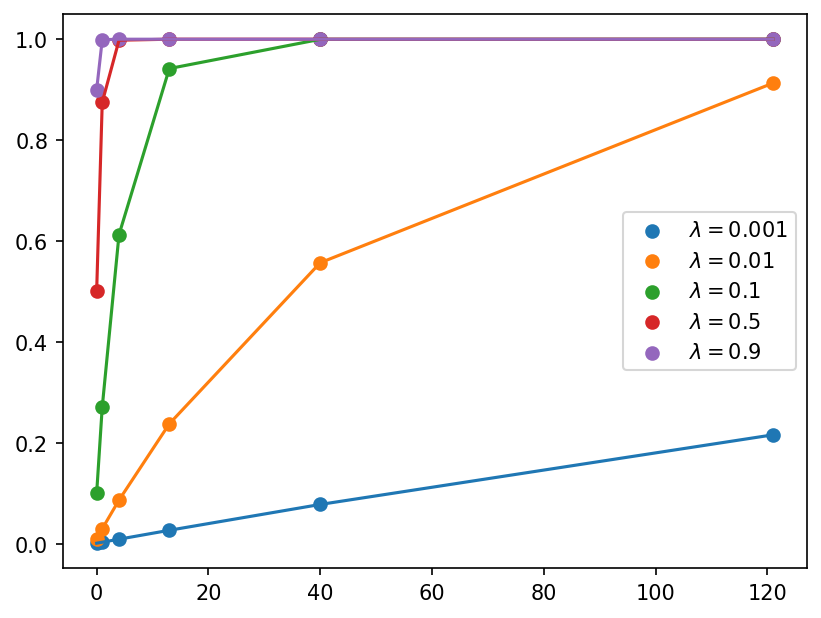

In [5]:
plt.figure(dpi=150)
for _lambda in lambda_list:
    l_list = [0]
    p_list = [_lambda]
    alpha_list = np.zeros(0)
    for _ in range(int(np.ceil(np.log(max_l)/np.log(3)))):
        alpha_list = np.concatenate((alpha_list, -alpha_list[::-1], np.ones(1)*(np.pi/3), alpha_list))
        beta_list = alpha_list[::-1]
        l_list.append(len(alpha_list))
        p_list.append(success_probability(alpha_list, beta_list, np.sqrt(1-_lambda)))
    plt.scatter(l_list, p_list, label=f'$\\lambda={_lambda}$')
    plt.plot(l_list, p_list)
plt.legend()
plt.show()

### The optimal fixed-point search

The $\alpha$ and $\beta$ list is defined as:

$$
\alpha_j = \beta_{l-j+1} = \pi + 2\arctan\left[ \sqrt{1-\gamma^2} \tan\frac{2\pi j}{L} \right],
$$

where $\gamma=1/T_L^{-1}(1/\delta)$, where $\delta\in(0,1)$ is a pre-determined parameter and $T_L$ is the $L$-th Chebyshev polynomial of the first kind.
Note that different $l$ shares no common sub-sequence of $\alpha$ and $\beta$.

The success probability is,

$$
P_L = 1 - \delta^2 T_L^2(\sqrt{1-\lambda}T_L^{-1}(1/\delta)).
$$

```{warning}
I cannot figure out the proof. *The original paper really spares words like gold...*
```

In [19]:
def inv_chebyt_inv(L:int, delta:float):
    '''Assert 0 < delta < 1'''
    # Since T_L'(1) = L^2 and T_L is convex at x>1, T_L^{-1}(y) where y > 1 must lie in [1-(y-1)/(L(L+1)), 1].
    return brentq(lambda gamma: eval_chebyt(L, 1/gamma) - 1/delta,
                    1 / (1 + (1/delta - 1) / L**2),
                    1) if L>1 else delta

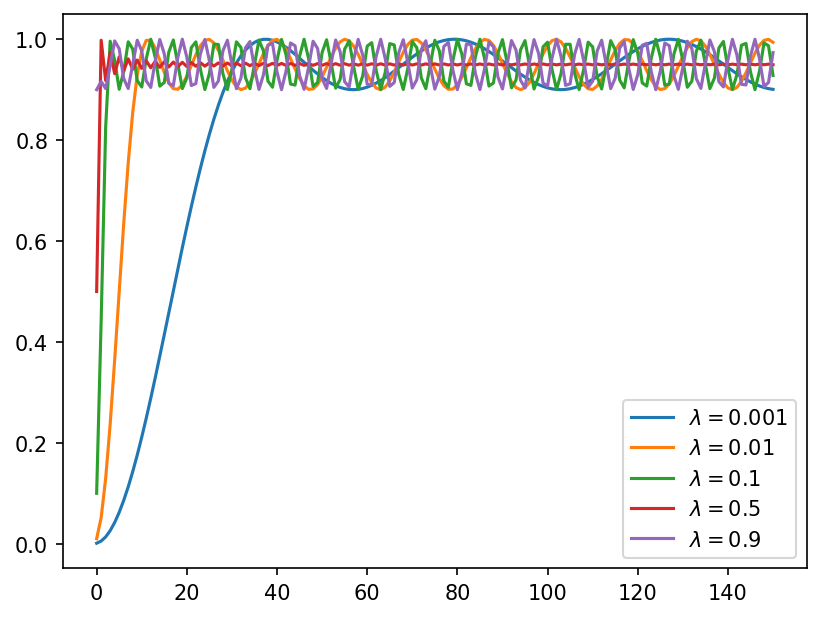

In [20]:
delta = 0.1**0.5

fpqs_alpha_dict = {}
fpqs_beta_dict = {}
for l in range(max_l+1):
    fpqs_alpha_dict[l] = np.array([np.pi + 2 * np.arctan(
        np.tan(2 * np.pi * j / (l*2+1)) * np.sqrt(1 - inv_chebyt_inv(l*2+1, delta)**2)
        ) for j in range(1,l+1)])
    fpqs_beta_dict[l]  = fpqs_alpha_dict[l][::-1]

plt.figure(dpi=150)
for _lambda in lambda_list:
    plt.plot(range(max_l+1),
            [success_probability(fpqs_alpha_dict[l], fpqs_beta_dict[l], np.sqrt(1-_lambda)) for l in range(max_l+1)],
            label=f'$\\lambda={_lambda}$')
plt.legend()
plt.show()

## A verification of the theoretical probability
# plt.figure(dpi=150)
# for _lambda in lambda_list:
#     plt.plot(range(max_l+1),
#             [1 - (delta*eval_chebyt(l*2+1,np.sqrt(1-_lambda)/inv_chebyt_inv(l*2+1, delta)))**2 for l in range(max_l+1)],
#             label=f'$\\lambda={_lambda}$')
# plt.legend()
# plt.show()

The character of the optimal fixed-point search is that when $l$ is larger than a critical level, the success probability fluctuates between $[1-\delta^2,1]$.
Also, we fix $\lambda=0.001$ and have a look at the success rate for different $\delta$.

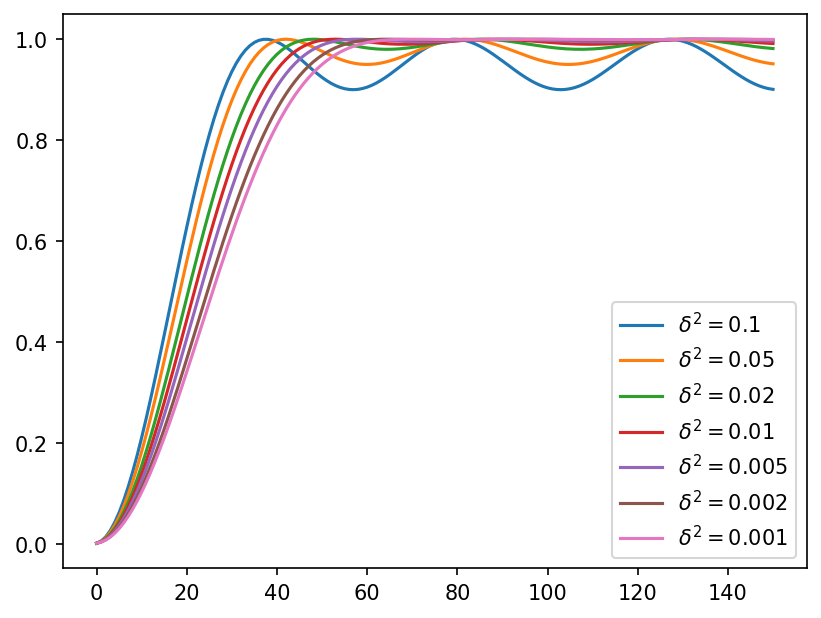

In [24]:
range_lambda = np.arange(0.0001, 1.0001, 0.001)
plt.figure(dpi=150)
for delta in [0.1**0.5, 0.05**0.5, 0.02**0.5, 0.01**0.5, 0.005**0.5, 0.002**0.5, 0.001**0.5]:
    plt.plot(range(max_l+1),
                [1 - (delta*eval_chebyt(l*2+1,np.sqrt(0.999)/inv_chebyt_inv(l*2+1,delta)))**2 for l in range(max_l+1)],
                label=f'$\\delta^2={np.round(delta**2,3)}$')
plt.legend()
plt.show()

## Comparison

A comparison of the success rate of the three methods at $l=13$. One can see that the success rate of the optimal fixed-point search goes as fast as Grover's search at small $\lambda$.

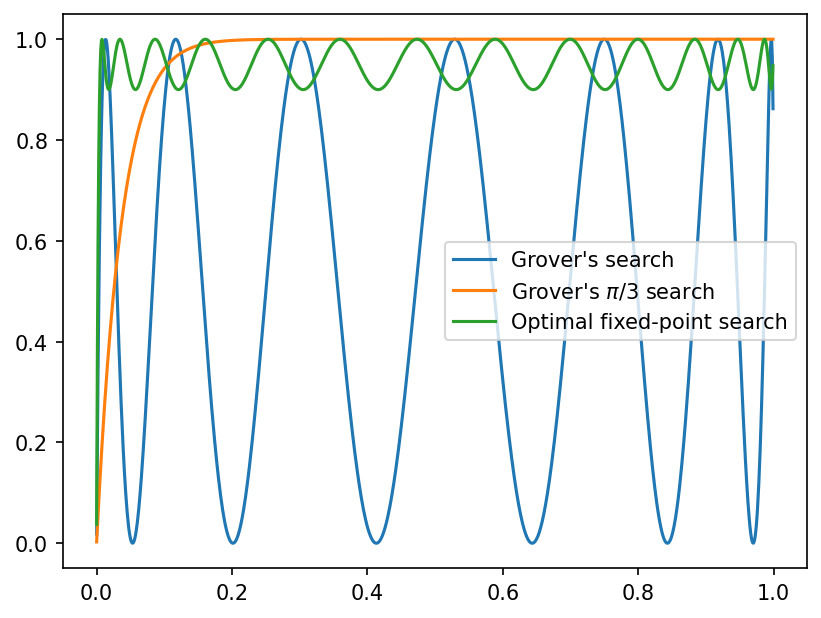

In [26]:
l = 13
plt.figure(dpi=150)
plt.plot(range_lambda, np.sin((2*l+1)*np.arcsin(range_lambda**0.5)/2)**2, label='Grover\'s search')
plt.plot(range_lambda, 1-(1-range_lambda)**(l*2+1), label='Grover\'s $\\pi/3$ search')
plt.plot(range_lambda, 1-0.1*eval_chebyt(l*2+1,np.sqrt(1-range_lambda)/inv_chebyt_inv(l*2+1,0.1**0.5))**2, label='Optimal fixed-point search')
plt.legend()
plt.show()

## References

### Grover's search

```
@inproceedings{grover1996fast,
  title={A fast quantum mechanical algorithm for database search},
  author={Grover, Lov K},
  booktitle={Proceedings of the twenty-eighth annual ACM symposium on Theory of computing},
  pages={212--219},
  year={1996}
}
```

### Grover's $\pi/3$ fixed-point search

```
@article{grover2005fixed,
  title={Fixed-point quantum search},
  author={Grover, Lov K},
  journal={Physical Review Letters},
  volume={95},
  number={15},
  pages={150501},
  year={2005},
  publisher={APS}
}
```

### Optimal fixed-point search

```
@article{yoder2014fixed,
  title={Fixed-point quantum search with an optimal number of queries},
  author={Yoder, Theodore J and Low, Guang Hao and Chuang, Isaac L},
  journal={Physical review letters},
  volume={113},
  number={21},
  pages={210501},
  year={2014},
  publisher={APS}
}
```

### Others

**Grover's Search is Optimal**

```
@article{zalka1999grover,
  title={Grover’s quantum searching algorithm is optimal},
  author={Zalka, Christof},
  journal={Physical Review A},
  volume={60},
  number={4},
  pages={2746},
  year={1999},
  publisher={APS}
}
```

**Grover's Search without priori knowledge**

```
@article{boyer1998tight,
  title={Tight bounds on quantum searching},
  author={Boyer, Michel and Brassard, Gilles and H{\o}yer, Peter and Tapp, Alain},
  journal={Fortschritte der Physik: Progress of Physics},
  volume={46},
  number={4-5},
  pages={493--505},
  year={1998},
  publisher={Wiley Online Library}
}
```